In [1]:
import os
import sys
import matplotlib.pyplot as pyplot
import numpy
from MDAnalysis import AtomGroup, Universe
from matplotlib.legend import Legend
from numpy import ndarray
from typing import List

base_dir: str = os.getcwd()
os.environ['LAMMPS_PYTHON_BASE_PATH'] =  os.path.join(base_dir, '../../../../md-analysis-tutorial/python/src')
sys.path.append(os.getenv('LAMMPS_PYTHON_BASE_PATH'))

os.environ['CNT_BREAKABLE_BONDS_PYTHON_BASE_PATH'] =  os.path.join(base_dir, '../python/src/visualisation')
sys.path.append(os.getenv('CNT_BREAKABLE_BONDS_PYTHON_BASE_PATH'))

from breakable_cnt_bonds_plot import BreakableCNTBondsPlot

## MDAnalysis Universe Class
* The MDAnalysis Universe class contains all the information describing the system.
* There are no required constructor arguments, but to generating a universe will generally require a topology file containing atomic information (in this case `./cnt_atomic.data`), and optionally an MD simulation trajactory/coordinate file (in this case `./cnt_breakable_bonds_dump.lammpstrj`)
* However, some topology files can contain both atomic information **and** coordinate data (e.g. XYZ, PDB, GRO or CRD files)
* Additionally, any file you provide you need to add an additional constructor argument for the file format
* Here, we have also added the following additional constructor arguments
  * `atom_style` - Specifies the atoms ID , type and scaled x, y, z coordinates (xs, ys, zs)
  * `guess_bonds` - Instructs MDAnalysis to guess the bonds between the atoms based on their distances. This is used when bond information is not explicitly provided in the topology file, as it is here since we are using the AIREBO force field
  * `vdwradii = {'1':1.7}` - A dictionary that maps atom types to their VDW radaii. In this case, atom type 1 is assigned a VDW radius of 1.7

In [2]:
md_universe: Universe = Universe(
    os.path.join(base_dir, "../data/raw/topology/cnt_atomic.data"),
    os.path.join(base_dir, "../data/raw/trajectory/cnt_breakable_bonds_dump.lammpstrj"),
    topology_format="data",
    format="lammpsdump",
    atom_style='id type x y z',
    guess_bonds=True,
    vdwradii={'1': 1.7}
)

# MD Analysis Universe.select_atoms and AtomGroup Class
* The method `Universe.select_atoms` returns an AtomGroup object
* The AtomGroup class is essentially an ordered array of atoms, with their order reflecting their order defined in the molecular topology file
* It therefore supports looping, indexing & slicing like a standard Python list
* Additionally, the class has properties representing coordinates, velocities, masses, charges, atom names, residues etc
* It also has methods for calculating properties such as distances, angles, dihedrals, center of mass, as well as methods for atomic transformation & manipulation such as translation, rotation etc

In [3]:
# Instantiate carbon atoms (atom type 1) AtomGroup object, and perform basic MD analysis
cnt: AtomGroup = md_universe.select_atoms("type 1")

# Basic MDAnalysis - Number of atoms in CNT and number of timestep frames 
print("Number of atoms =", cnt.n_atoms)
print("Number of frames =", md_universe.trajectory.n_frames)

# Basic MDAnalysis - Access indexes of atoms that are considered bonded by the MDAnalysis bond guesser
print("Bonded Atoms =", cnt.atoms.bonds.indices)

# Basic MDAnalysis - Loop over all the timestep frames of the trajectory
for timestep in md_universe.trajectory:
    print("Timestep frame ", timestep.frame)

# Basic MDAnalysis - Extract Atomic Positions
md_universe.atoms.positions

Number of atoms = 700
Number of frames = 286
Bonded Atoms = [[  0   2]
 [  0  23]
 [  0  56]
 ...
 [696 697]
 [696 699]
 [698 699]]
Timestep frame  0
Timestep frame  1
Timestep frame  2
Timestep frame  3
Timestep frame  4
Timestep frame  5
Timestep frame  6
Timestep frame  7
Timestep frame  8
Timestep frame  9
Timestep frame  10
Timestep frame  11
Timestep frame  12
Timestep frame  13
Timestep frame  14
Timestep frame  15
Timestep frame  16
Timestep frame  17
Timestep frame  18
Timestep frame  19
Timestep frame  20
Timestep frame  21
Timestep frame  22
Timestep frame  23
Timestep frame  24
Timestep frame  25
Timestep frame  26
Timestep frame  27
Timestep frame  28
Timestep frame  29
Timestep frame  30
Timestep frame  31
Timestep frame  32
Timestep frame  33
Timestep frame  34
Timestep frame  35
Timestep frame  36
Timestep frame  37
Timestep frame  38
Timestep frame  39
Timestep frame  40
Timestep frame  41
Timestep frame  42
Timestep frame  43
Timestep frame  44
Timestep frame  45
Time

array([[ 75.14728 ,  78.17872 ,  95.61408 ],
       [ 75.33008 ,  77.751114,  93.20232 ],
       [ 75.550476,  77.34152 ,  94.54224 ],
       ...,
       [ 84.66992 ,  82.24888 , 143.84988 ],
       [ 84.66992 ,  82.24888 , 147.60156 ],
       [ 84.85272 ,  81.82128 , 146.26175 ]], dtype=float32)

# Counting CNT Bonds
In order to measure the evolution of the number of bonds over time, we will loop over the simulation trajectory and manually extract the inter-atomic distance over time. 

We will have a nested loop within this simulation trajectory loop, looping over the indices of the atoms that are detected as bonded and calculate the distance between the two atoms.

In [4]:
for timestep in md_universe.trajectory:
    # `cnt.atoms.bonds.indices` is a list of tuples and the expression `index_1, index_2` unpacks each tuple
    # index_1 and index_2 represent the indices of the two atoms in each bond
    for index_1, index_2 in cnt.atoms.bonds.indices:
        
        ## `md_universe.atoms.positions` provides the positions of all atoms in the current timestep as a NumPy array
        ## `md_universe.atoms.indices == index_1` creates a boolean array where the elements are True for the atom with index `index_1` and False otherwise
        ## `md_universe.atoms.positions[md_universe.atoms.indices == index_1]` uses this boolean array to filter the positions array, returning the position of the atom with index index_1.
        position_1 = md_universe.atoms.positions[md_universe.atoms.indices == index_1][0]
        position_2 = md_universe.atoms.positions[md_universe.atoms.indices == index_2][0]

        ## Calculate bond length as Euclidean distance
        bond_length: float = numpy.sqrt(numpy.sum((position_1 - position_2)**2))

        # If bond length is larger than 1.8 Å, the bond is broken


# Extract Mean Bond Lengths & Number of Bonds
Using the same method above, we will now store the mean length of the bonds and the total number of bonds in two separate lists.

In [5]:
# Instantiate carbon atoms (atom type 1) AtomGroup object
cnt_atom_group: AtomGroup = md_universe.select_atoms('type 1')

# Extract 'bond length vs timestep frame' and 'bond number vs timestep frame' data
BreakableCNTBondsPlot.extract_mean_bond_lengths_bond_numbers(
    md_universe=md_universe,
    cnt_atom_group=cnt_atom_group,
    bond_length_vs_timestep_path=os.path.join(
        base_dir,
        '../data/processed/bond-length-vs-time/bond_length_vs_timestep_frame.dat'
    ),
    bond_number_vs_timestep_path=os.path.join(
        base_dir,
        '../data/processed/bond-number-vs-time/bond_number_vs_timestep_frame.dat'
    )
)

# Create Matplotlib graph to plot 'bond length vs timestep frame' and 'bond number vs timestep frame' data
* We will now load the data from the to .dat files into two Numpy arrays
* We will then use slicing syntax (`bond_length_vs_timestep_frame[:, 0]`) to extract all the elements in the `bond_length_vs_timestep_frame[0]` sub-array, and `bond_length_vs_timestep_frame[:, 1]` to extract all the elements in the `bond_length_vs_timestep_frame[1]` sub-array
* The same will be done for `bond_number_vs_timestep_frame`

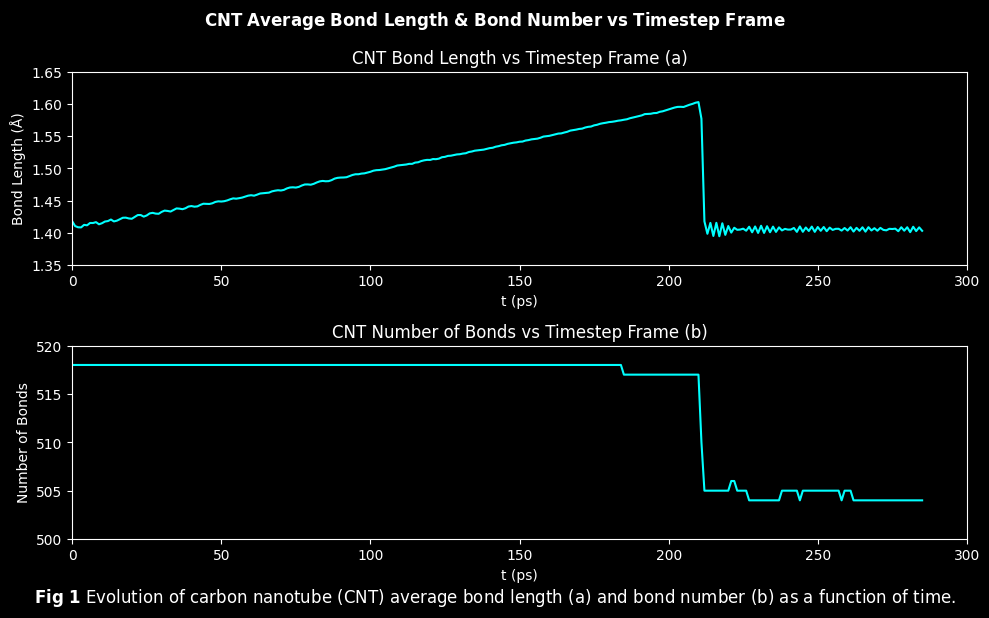

In [6]:
# Load 'bond length vs timestep frame' and 'bond number vs timestep frame' data
bond_length_vs_timestep_frame: ndarray = numpy.loadtxt(
    os.path.join(
        base_dir,
        "../data/processed/bond-length-vs-time/bond_length_vs_timestep_frame.dat"
    )
)
bond_number_vs_timestep_frame: ndarray = numpy.loadtxt(
    os.path.join(
        base_dir,
        "../data/processed/bond-number-vs-time/bond_number_vs_timestep_frame.dat"
    )
)

# Define subplot configurations
subplots_data_arrays: List[ndarray] = [bond_length_vs_timestep_frame, bond_number_vs_timestep_frame]

# Create 'bond length vs timestep frame' and 'bond number vs timestep frame' subplots
BreakableCNTBondsPlot.line_graph_subplots(
    data_arrays=subplots_data_arrays,
    subplot_titles=['CNT Bond Length vs Timestep Frame (a)', 'CNT Number of Bonds vs Timestep Frame (b)'],
    x_labels=['t (ps)', 't (ps)'],
    y_labels=['Bond Length (Å)', 'Number of Bonds'],
    x_lim=(0, 300),
    y_lims=[(1.35, 1.65), (500, 520)],
    graph_title=r'$\bf{CNT\ Average\ Bond\ Length\ &\ Bond\ Number\ vs\ Timestep\ Frame}$',
    figure_text=(
        r'$\bf{Fig\ 1}$ Evolution of carbon nanotube (CNT) average bond length (a) and bond number (b) as a '
        r'function of time.'
    ),
    save_path=os.path.join(base_dir, '../reports/figures/cnt_average_bond_length_bond_number_vs_timestep.png')
)

# Extract bond length distributions data at beginning of simulation, and at maximum CNT deformation

Using a similar script as before, we will extract the bond length distribution at the beginning of the simulation (let us say the 20 first frame), as well as near the maximum deformation of the CNT

In [7]:
# Extract bond length distribution data
BreakableCNTBondsPlot.extract_bond_length_distributions(
    md_universe=md_universe,
    cnt_atom_group=cnt,
    first_bond_length_distribution_path=(
        os.path.join(
            base_dir,
            '../data/processed/bond-length-distribution/starting_bond_length_distribution.dat'
        )
    ),
    second_bond_length_distribution_path=(
        os.path.join(
            base_dir,
            '../data/processed/bond-length-distribution/maximum_deformation_bond_length_distribution.dat'
        )
    ),
    bond_length_cutoff=1.8,
    number_of_bins=50,
    bond_length_range=(1.3, 1.65),
    first_frame_range=(0, 20),
    second_frame_range=(200, 220)
)

# Create Matplotlib graph to plot bond length distribution data at beginning of simulation, and at maximum CNT deformation

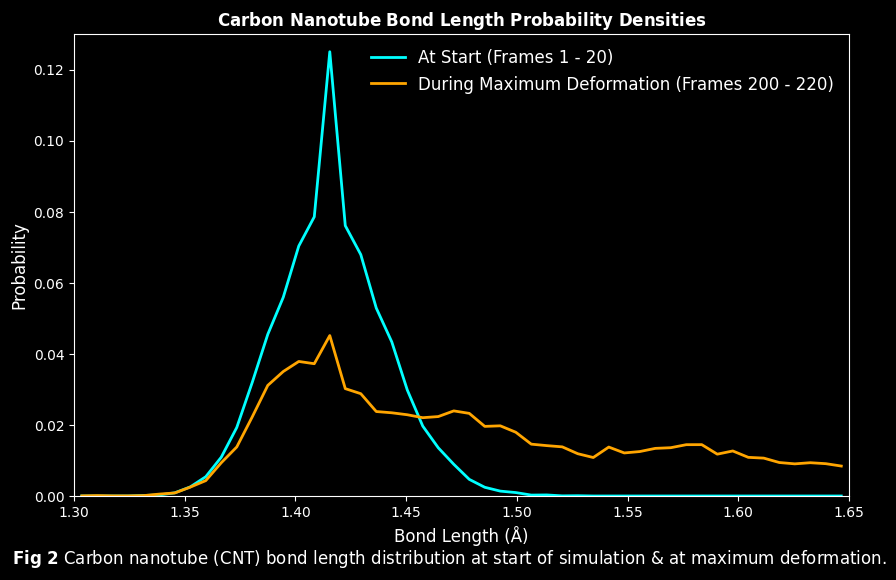

In [8]:
# Load bond length distribution data and plot on custom line graph
starting_bond_length_distributions_data = numpy.loadtxt(
    os.path.join(
        base_dir,
        '../data/processed/bond-length-distribution/starting_bond_length_distribution.dat'
    )
).T
maximum_deformation_bond_length_distributions_data = (
    numpy.loadtxt(
        os.path.join(
            base_dir,
            '../data/processed/bond-length-distribution/maximum_deformation_bond_length_distribution.dat'
        )
    ).T
)

# Create line graph to plot bond length probability densities
bond_length_distributions_data = [
    starting_bond_length_distributions_data,
    maximum_deformation_bond_length_distributions_data
]

BreakableCNTBondsPlot.single_line_graph(
    data_arrays=bond_length_distributions_data,
    figure_size=(10, 6),
    line_colours=['cyan', 'orange'],
    line_labels=['At Start (Frames 1 - 20)', 'During Maximum Deformation (Frames 200 - 220)'],
    x_label='Bond Length (Å)',
    y_label='Probability',
    x_lim=(1.30, 1.65),
    y_lim=(0.00, 0.13),
    graph_title=r'$\bf{Carbon\ Nanotube\ Bond\ Length\ Probability\ Densities}$',
    figure_text=(r'$\bf{Fig\ 2}$ Carbon nanotube (CNT) bond length distribution at start of simulation & at '
                 r'maximum deformation.'),
    figure_text_font_size=12,
    figure_text_x_coord=0.5,
    figure_text_y_coord=0.005,
    font_size=12,
    tick_label_size=10,
    line_width=2,
    save_path=os.path.join(base_dir, '../reports/figures/cnt_bond_length_distributions.png')
)